In [3]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [4]:
BASE_DIR = '../data/lego-minifigures'
PATH_INDEX = pd.read_csv('../data/lego-minifigures/index.csv')

In [5]:
config = {
    'test_size': 0.3,
    'img_size': 64,
    'batch_size': 32,
    'learning_rate': 1e-3,
    'epochs': 32
}

In [6]:
class LegoDataset(Dataset):
    def __init__(self, base_dir, path_index, transforms):
        self.data_path = base_dir
        self.path_index = path_index
        self.transforms = transforms

    def __len__(self):
        return len(self.path_index)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.data_path, self.path_index.iloc[index, 0])
        img = Image.open(img_path)

        img = self.transforms(img)

        return img, self.path_index.iloc[index, 1]
    


In [7]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.9, 1.1)),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=10),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor()  
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_paths, test_paths = train_test_split(PATH_INDEX, test_size=config['test_size'], random_state=42)

In [8]:
train_dataset = LegoDataset(BASE_DIR, train_paths.reset_index(drop=True), train_transforms)
test_dataset = LegoDataset(BASE_DIR, test_paths.reset_index(drop=True), test_transforms)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = config['batch_size'], shuffle=False)

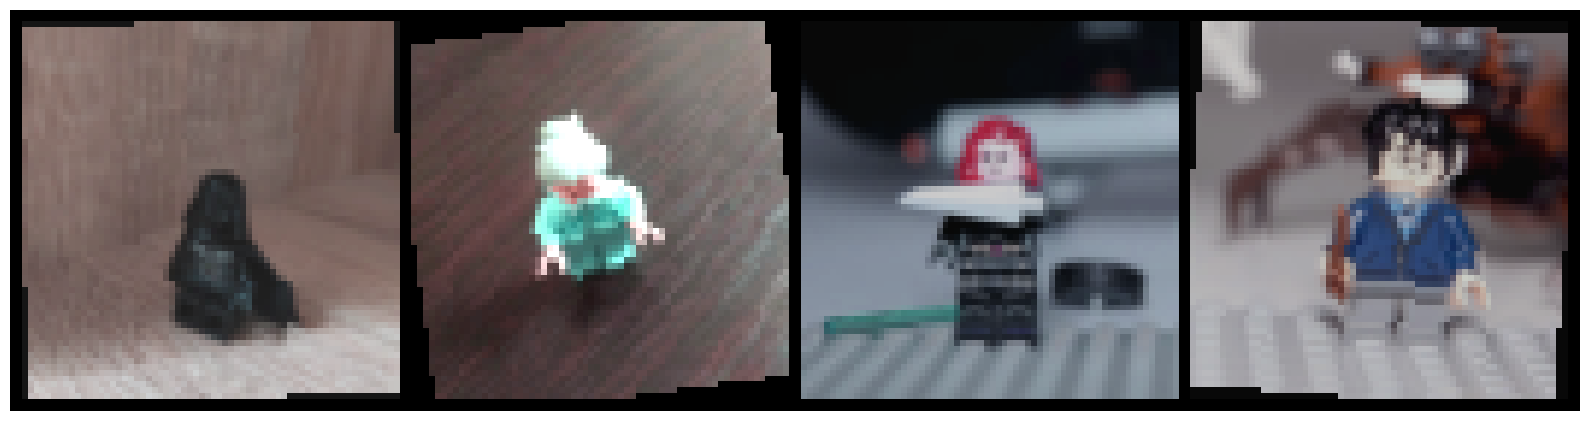

In [10]:
samples, labels = next(iter(train_dataloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:4])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.axis('off')
plt.tight_layout()
plt.show()

In [101]:
class AutoEncoder(nn.Module):
    def __init__(self, grey_scale = False):
        super().__init__()

        input_channels = 3

        if grey_scale:
            input_channels = 1

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, stride=(1, 1), kernel_size=(3, 3), padding=1), 
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(5, 5), padding=2),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(5, 5), padding=2),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(5, 5), padding=2),
            nn.Flatten(),
            nn.Linear(4096, 128)
        )

        self.decoder = nn.Sequential(
            nn.Linear(128, 4096),
            nn.Unflatten(1, (64, 8 , 8)),
            nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(5, 5), padding=2, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(5,5), padding=2, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=2, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32, input_channels, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [102]:
#define model
autoencoder_model = AutoEncoder()

In [ ]:
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr = config['learning_rate'])
criterion = nn.MSELoss()
train_loss = []
val_loss = []

for epoch in range(config['epochs']):
    
    epoch_train_loss = []
    epoch_val_loss = []

    autoencoder_model.train()
    for images, _ in train_dataloader:
        reconstructed_imgs = autoencoder_model(images)

        loss = criterion(reconstructed_imgs, images)
        epoch_train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    autoencoder_model.eval()
    for images, _ in test_dataloader:
        with torch.no_grad():
            reconstructed_imgs = autoencoder_model(images)
            loss = criterion(reconstructed_imgs, images)
            epoch_val_loss.append(loss.item())
        
    train_loss.append(sum(epoch_train_loss) / len(epoch_train_loss))
    val_loss.append(sum(epoch_val_loss) / len(epoch_val_loss))

    print(f'Epoch: {epoch} Training loss: {train_loss[epoch]:.4f} | Validation loss: {val_loss[epoch]:.4f}')


Epoch: 0 Training loss: 0.0786 | Validation loss: 0.0692
Epoch: 1 Training loss: 0.0734 | Validation loss: 0.0694
Epoch: 2 Training loss: 0.0769 | Validation loss: 0.0590
Epoch: 3 Training loss: 0.0684 | Validation loss: 0.0511
Epoch: 4 Training loss: 0.0557 | Validation loss: 0.0506
Epoch: 5 Training loss: 0.0496 | Validation loss: 0.0463
Epoch: 6 Training loss: 0.0442 | Validation loss: 0.0355
Epoch: 7 Training loss: 0.0388 | Validation loss: 0.0332
Epoch: 8 Training loss: 0.0385 | Validation loss: 0.0313
Epoch: 9 Training loss: 0.0346 | Validation loss: 0.0292
Epoch: 10 Training loss: 0.0332 | Validation loss: 0.0283
Epoch: 11 Training loss: 0.0326 | Validation loss: 0.0264
Epoch: 12 Training loss: 0.0316 | Validation loss: 0.0265
Epoch: 13 Training loss: 0.0300 | Validation loss: 0.0257
Epoch: 14 Training loss: 0.0303 | Validation loss: 0.0256
Epoch: 15 Training loss: 0.0281 | Validation loss: 0.0247
Epoch: 16 Training loss: 0.0273 | Validation loss: 0.0235
Epoch: 17 Training loss:

In [ ]:
with torch.no_grad():
    plt.plot(train_loss, color='blue', label='Training Loss')
    plt.plot(val_loss, color = 'orange', label = 'Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss for the Autoencoder Model')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

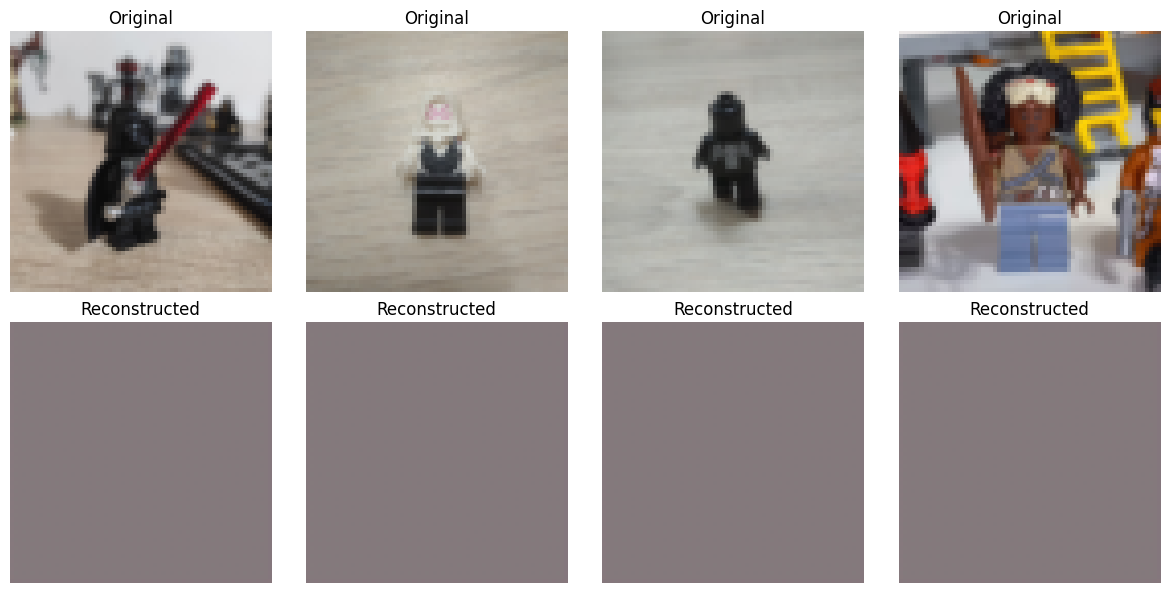

In [103]:
test_images, labels = next(iter(test_dataloader))

test_images = test_images[:4]

# Get the reconstructed images
with torch.no_grad():
    reconstructed_imgs = autoencoder_model(test_images)

# Create a grid to compare original and reconstructed images
fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 
for i, ax in enumerate(axes[0]):
    ax.imshow(test_images[i].permute(1, 2, 0).numpy())  
    ax.set_title("Original")
    ax.axis("off")

for i, ax in enumerate(axes[1]):
    ax.imshow(reconstructed_imgs[i].permute(1, 2, 0).numpy())  
    ax.set_title("Reconstructed")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [104]:
encoder_model = autoencoder_model.encoder
with torch.no_grad():
    print(encoder_model(test_images))

tensor([[-1.7635e-02, -2.2876e-03,  9.5969e-04, -2.5278e-02,  8.9326e-03,
         -1.6917e-03, -2.1834e-03,  5.1293e-03,  1.2129e-02,  2.7147e-02,
          7.6543e-03,  6.5217e-03,  2.4392e-02,  3.7289e-03, -1.0860e-02,
          1.6287e-03, -3.5371e-03,  2.7133e-03,  1.0851e-02,  6.0625e-03,
         -9.4545e-03,  8.7713e-03, -1.7821e-03, -1.1332e-02,  1.4563e-02,
         -1.6435e-02, -7.9286e-03, -8.2338e-04,  6.7510e-03,  4.7035e-03,
          1.6239e-02,  1.0349e-03, -2.5262e-03,  1.2109e-02, -1.5038e-02,
         -3.0574e-03, -3.7480e-03, -3.0782e-02, -1.7878e-02,  1.1772e-02,
          5.0848e-03, -2.5431e-02,  1.4274e-02,  1.3916e-02, -1.8006e-02,
          9.5156e-03, -1.0742e-03, -1.5662e-02, -1.8248e-02,  1.6764e-02,
         -9.9542e-03,  8.7389e-03, -2.2747e-03,  1.3414e-02, -9.9821e-03,
         -1.5390e-02, -1.1841e-02, -9.8328e-03,  8.8538e-03, -3.6159e-02,
         -1.0787e-03, -1.5966e-02,  1.0258e-02,  1.0384e-02, -1.4699e-02,
         -2.0890e-02,  4.8121e-04, -2.

In [122]:
class VAE(nn.Module):
    def __init__(self, grey_scale = False):
        super().__init__()
        input_channels = 3

        if grey_scale:
            input_channels = 1

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, stride=(1, 1), kernel_size=(3, 3), padding=1), 
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(5, 5), padding=2),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(5, 5), padding=2),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(5, 5), padding=2),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(4096, 128)
        self.z_log_var = nn.Linear(4096, 128)
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 4096),
            nn.Unflatten(1, (64, 8 , 8)),
            nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(5, 5), padding=2, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(5,5), padding=2, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=2, output_padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32, input_channels, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.Sigmoid()  
        )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparametrize(z_mean, z_log_var)
        return encoded
    
    def reparametrize(self, z_mean, z_log_var):
        eps = torch.randn(z_mean.size(0), z_mean.size(1))
        z = z_mean + eps * torch.exp(z_log_var/2.) 
        return z
    
    def forward(self,x):
        x=self.encoder(x)
        z_mean, z_log_var =self.z_mean(x), self.z_log_var(x)
        encoded =self.reparametrize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [123]:
def vae_loss(reconstructed, original, mu, logvar):
    recon_loss = F.mse_loss(reconstructed, original, reduction='sum')  
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [124]:
vae_model = VAE()

In [ ]:
optimizer = torch.optim.Adam(vae_model.parameters(), lr = config['learning_rate'])
criterion = nn.MSELoss()
train_loss = []
val_loss = []

for epoch in range(config['epochs']):
    
    epoch_train_loss = []
    epoch_val_loss = []

    vae_model.train()
    for images, _ in train_dataloader:
        encoded, z_mean, z_log_var, decoded  = vae_model(images)

        loss = vae_loss(decoded, images, z_mean, z_log_var)
        epoch_train_loss.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    vae_model.eval()
    for images, _ in test_dataloader:
        with torch.no_grad():
            encoded, z_mean, z_log_var, decoded = vae_model(images)
            loss = vae_loss(decoded, images, z_mean, z_log_var)
            epoch_val_loss.append(loss)
    
    with torch.no_grad():    
        train_loss.append(sum(epoch_train_loss) / len(epoch_train_loss))
        val_loss.append(sum(epoch_val_loss) / len(epoch_val_loss))

    print(f'Epoch: {epoch} Training loss: {train_loss[epoch]:.4f} | Validation loss: {val_loss[epoch]:.4f}')

Epoch: 0 Training loss: 30194.3262 | Validation loss: 24290.1680
Epoch: 1 Training loss: 27084.3047 | Validation loss: 26320.7344
Epoch: 2 Training loss: 27189.8320 | Validation loss: 24049.4375
Epoch: 3 Training loss: 25488.2188 | Validation loss: 20412.1445
Epoch: 4 Training loss: 22240.0293 | Validation loss: 16876.0430
Epoch: 5 Training loss: 19863.5645 | Validation loss: 15107.3301
Epoch: 6 Training loss: 18256.3809 | Validation loss: 13612.9229
Epoch: 7 Training loss: 17272.0117 | Validation loss: 13916.5195
Epoch: 8 Training loss: 16924.9492 | Validation loss: 12887.8711
Epoch: 9 Training loss: 15950.2363 | Validation loss: 12833.5527
Epoch: 10 Training loss: 15397.0918 | Validation loss: 12019.5039
Epoch: 11 Training loss: 15569.9883 | Validation loss: 11879.8916
Epoch: 12 Training loss: 14828.6514 | Validation loss: 12590.3594
Epoch: 13 Training loss: 15058.4258 | Validation loss: 12147.1875
Epoch: 14 Training loss: 15278.1514 | Validation loss: 11964.8848
Epoch: 15 Training l

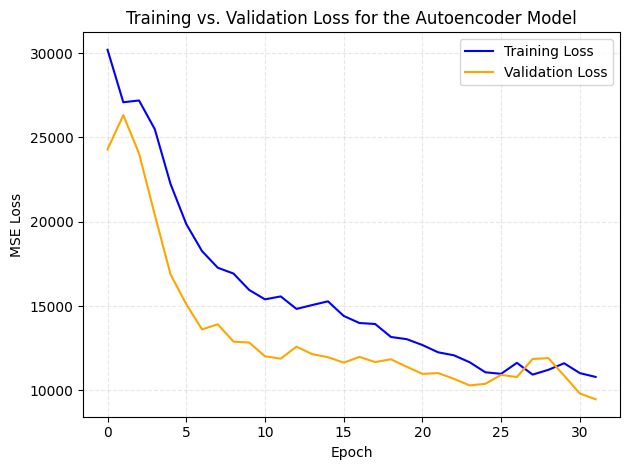

In [ ]:
with torch.no_grad():
    plt.plot(train_loss, color='blue', label='Training Loss')
    plt.plot(val_loss, color = 'orange', label = 'Validation Loss')
plt.legend()
plt.title('Training vs. Validation Loss for the VAE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

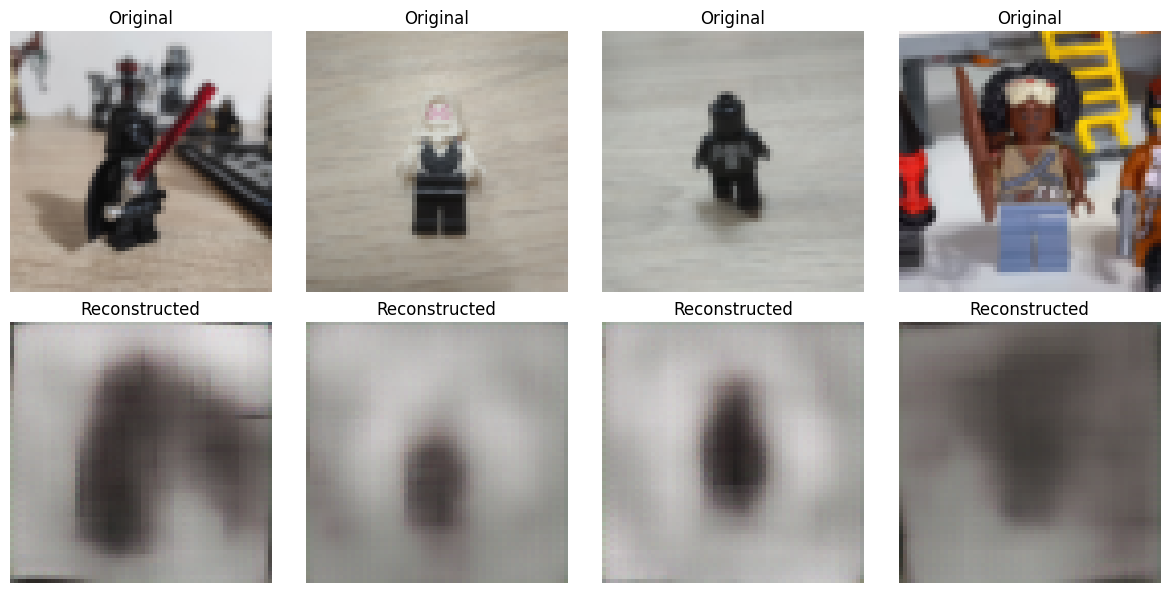

In [126]:
with torch.no_grad():
    reconstructed_imgs = vae_model(test_images)[-1]

# Create a grid to compare original and reconstructed images
fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 
for i, ax in enumerate(axes[0]):
    ax.imshow(test_images[i].permute(1, 2, 0).numpy())  
    ax.set_title("Original")
    ax.axis("off")

for i, ax in enumerate(axes[1]):
    ax.imshow(reconstructed_imgs[i].permute(1, 2, 0).numpy())  
    ax.set_title("Reconstructed")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [129]:
with torch.no_grad():
    print(vae_model.encoding_fn(test_images))

tensor([[ 3.0063e-01,  6.0921e-01, -9.3411e-01, -8.2644e-02, -5.5738e-01,
          1.3922e+00,  6.0418e-01,  1.6748e+00,  2.0082e-01,  1.0302e+00,
         -2.7291e-01,  9.9237e-01,  7.7010e-01, -1.4754e+00,  4.5057e-01,
          1.2199e+00, -1.1148e+00, -1.6279e+00, -8.0504e-02,  4.1690e-01,
          6.4627e-01, -9.3333e-02,  1.8153e-01,  8.9514e-01, -5.7813e-03,
          8.4846e-01,  1.4683e-01,  9.4503e-01,  5.4311e-01, -1.3089e+00,
          8.3779e-01,  2.4619e-01, -2.0558e+00,  6.8431e-01, -2.1813e-01,
         -6.1880e-01, -5.4546e-01, -1.9597e-01, -1.1973e+00,  1.9728e+00,
          8.2189e-01,  2.1737e+00, -4.7416e-01, -9.8608e-01,  1.7951e+00,
         -5.5710e-01, -1.8226e-01, -2.0169e+00,  8.2329e-01, -1.1160e+00,
         -2.0752e-01, -8.8341e-01, -3.9862e-01, -2.9149e-01, -1.7949e+00,
          2.1024e-01, -8.7260e-02,  3.6354e-02,  3.1834e-01,  1.3331e+00,
         -2.3680e+00, -1.2705e-01, -1.1812e+00, -3.1609e-01, -4.6945e-01,
          8.8763e-01, -3.3810e-01,  4.

In [15]:
class GAN(nn.Module):
    def __init__(self, latent_dim=128, image_size=64, color_channels=3):
        super().__init__()
        self.image_size = image_size
        self.color_channels = color_channels
        self.latent_dim = latent_dim

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, image_size * 8, kernel_size=4, stride=1, padding=0),  # (N, 512, 4, 4)
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1),  # (N, 256, 8, 8)
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1),  # (N, 128, 16, 16)
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1),  # (N, 64, 32, 32)
            nn.BatchNorm2d(image_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(image_size, color_channels, kernel_size=4, stride=2, padding=1),  # (N, 3, 64, 64)
            nn.Sigmoid()  
        )
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size= 5, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Flatten(),
            nn.Linear(64*7*7 ,1),
            nn.Sigmoid()
        )

    def forward(self, z, mode='generator'):
        if mode == 'generator':
            return self.generator_forward(z)
        elif mode == 'discriminator':
            return self.discriminator_forward(z)
        else:
            raise ValueError("Mode must be 'generator' or 'discriminator'")

    def generator_forward(self, z):
        img = self.generator(z)
        img = img.view(z.size(0), self.color_channels, self.image_size, self.image_size)
        return img

    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits

In [16]:
gan_model = GAN()

In [17]:
gen_optimizer = torch.optim.Adam(gan_model.generator.parameters(), lr = config['learning_rate'])
discr_optimizer = torch.optim.Adam(gan_model.discriminator.parameters(), lr = config['learning_rate'])

In [28]:
criterion = nn.BCELoss()

logging_interval = 5

train_loss_gen = []
train_loss_disc = []

for epoch in range(config['epochs']):

    epoch_train_loss_gen = []
    epoch_train_loss_disc = []

    gan_model.train()
    for real_images, _ in train_dataloader:

        batch_size = real_images.size(0)

        real_labels = torch.ones(batch_size)
        input_noise = torch.randn(batch_size, 128, 1, 1)

        fake_images = gan_model(input_noise, mode='generator')
        fake_labels = torch.zeros(batch_size)

        ######################
        # Discriminator
        #####################
        discr_optimizer.zero_grad()

        pred_real_images = gan_model(real_images, mode='discriminator').view(-1)
        pred_fake_images = gan_model(fake_images.detach(), mode='discriminator').view(-1)

        real_loss = criterion(pred_real_images, real_labels)
        fake_loss = criterion(pred_fake_images, fake_labels)

        discr_loss = 0.5 * (real_loss + fake_loss)
        discr_loss.backward()

        discr_optimizer.step()

        ######################
        # Generator
        #####################
        gen_optimizer.zero_grad()

        pred_fake_images = gan_model(fake_images, mode='discriminator').view(-1)
        gen_loss = criterion(pred_fake_images, real_labels)
        gen_loss.backward()

        gen_optimizer.step()

        epoch_train_loss_disc.append(discr_loss.item())
        epoch_train_loss_gen.append(gen_loss.item())
    
    train_loss_disc.append(sum(epoch_train_loss_disc) / len(epoch_train_loss_disc))
    train_loss_gen.append(sum(epoch_train_loss_gen) / len(epoch_train_loss_gen))

    print('Epoch: %03d/%03d | Batches: %d | Gen/Dis Loss: %.4f/%.4f' 
                % (epoch+1, config['epochs'], 
                len(train_dataloader), train_loss_gen[epoch], train_loss_disc[epoch]))




Epoch: 001/032 | Batches: 9 | Gen/Dis Loss: 4.5337/0.1308
Epoch: 002/032 | Batches: 9 | Gen/Dis Loss: 5.2793/0.0935
Epoch: 003/032 | Batches: 9 | Gen/Dis Loss: 5.3722/0.0751
Epoch: 004/032 | Batches: 9 | Gen/Dis Loss: 5.1651/0.0502
Epoch: 005/032 | Batches: 9 | Gen/Dis Loss: 4.8713/0.0350
Epoch: 006/032 | Batches: 9 | Gen/Dis Loss: 5.7081/0.0352
Epoch: 007/032 | Batches: 9 | Gen/Dis Loss: 5.4927/0.0449
Epoch: 008/032 | Batches: 9 | Gen/Dis Loss: 6.3866/0.0127
Epoch: 009/032 | Batches: 9 | Gen/Dis Loss: 5.8863/0.0163
Epoch: 010/032 | Batches: 9 | Gen/Dis Loss: 6.7366/0.0248
Epoch: 011/032 | Batches: 9 | Gen/Dis Loss: 6.6667/0.0292
Epoch: 012/032 | Batches: 9 | Gen/Dis Loss: 6.0043/0.0107
Epoch: 013/032 | Batches: 9 | Gen/Dis Loss: 5.9651/0.0135
Epoch: 014/032 | Batches: 9 | Gen/Dis Loss: 6.9116/0.0155
Epoch: 015/032 | Batches: 9 | Gen/Dis Loss: 6.7633/0.0161
Epoch: 016/032 | Batches: 9 | Gen/Dis Loss: 7.2713/0.0088
Epoch: 017/032 | Batches: 9 | Gen/Dis Loss: 7.6333/0.0062
Epoch: 018/032

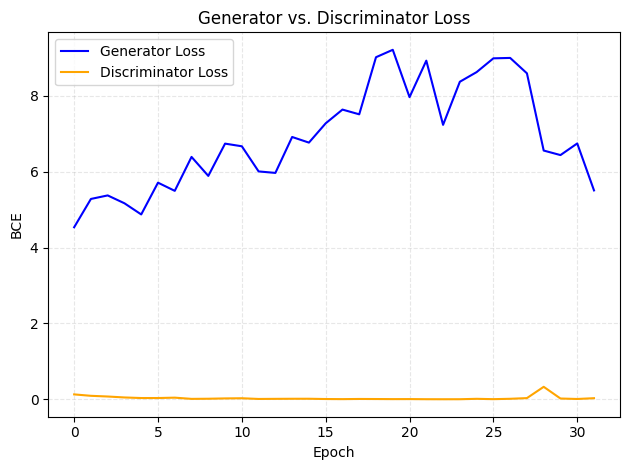

In [29]:
with torch.no_grad():
    plt.plot(train_loss_gen, color='blue', label='Generator Loss')
    plt.plot(train_loss_disc, color = 'orange', label = 'Discriminator Loss')
plt.legend()
plt.title('Generator vs. Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('BCE')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

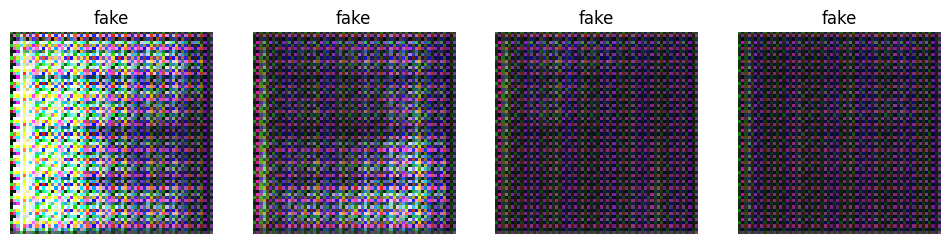

In [37]:
with torch.no_grad():
    test_noise = torch.randn(4, 128, 1, 1)
    generated_images = gan_model(test_noise, mode='generator')

    discr_labels = gan_model(generated_images, mode ='discriminator')
    classified_labels = ["fake" if label < 0.5 else "real" for label in discr_labels]

    fig, axes = plt.subplots(1, 4, figsize=(12, 6)) 
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(generated_images[i].permute(1, 2, 0).numpy())  
        ax.set_title(classified_labels[i])
        ax.axis("off")

    plt.show()